# Build a Milvus Powered Text-Image Search Engine in Minutes

This notebook illustrates how to build an text-image search engine from scratch using [Milvus](https://milvus.io/). Milvus is the most advanced open-source vector database built for AI applications and supports nearest neighbor embedding search across tens of millions of entries. We'll go through text-image search procedures and evaluate the performance. Moreover, we managed to make the core functionality as simple as 15 lines of code, with which you can start hacking your own image search engine.

## Preparation

### Prepare the data

First, we need to prepare the dataset and Milvus environment. A subset of the ImageNet dataset (100 classes, 10 images for each class) is used in this demo, and the dataset is available via [Google Drive](https://drive.google.com/file/d/1lRhHODcFXUEHf7n-GFlvYgBikhg81KbB/view?usp=sharing) and [Github](https://github.com/towhee-io/data/raw/main/image/reverse_image_search.zip). 

The dataset is organized as follows:
- **train**: directory of candidate images;
- **test**: directory of the query images;
- **reverse_image_search.csv**: a csv file containing an ***id***, ***path***, and ***label*** for each image;

Let's take a quick look:

In [1]:
! curl -L https://github.com/towhee-io/data/raw/main/image/reverse_image_search.zip -O
! unzip -q -o reverse_image_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  2664k      0  0:00:46  0:00:46 --:--:-- 5585k


In [2]:
import pandas as pd

df = pd.read_csv('reverse_image_search.csv')
df.head()

,id,path,label
0,0,./train/brain_coral/n01917289_1783.JPEG,brain_coral
1,1,./train/brain_coral/n01917289_4317.JPEG,brain_coral
2,2,./train/brain_coral/n01917289_765.JPEG,brain_coral
3,3,./train/brain_coral/n01917289_1079.JPEG,brain_coral
4,4,./train/brain_coral/n01917289_2484.JPEG,brain_coral


To use the dataset for image search, let's first define some helper functions:

- **read_images(results)**: read images by image IDs;
- **ground_truth(path)**: ground-truth for each query image, which is used for calculating mHR(mean hit ratio) and mAP(mean average precision);

In [3]:
import cv2
from towhee._types.image import Image

id_img = df.set_index('id')['path'].to_dict()
label_ids = {}
for label in set(df['label']):
    label_ids[label] = list(df[df['label']==label].id)

def read_images(results):
    imgs = []
    for re in results:
        path = id_img[re.id]
        imgs.append(Image(cv2.imread(path), 'BGR'))
    return imgs

def ground_truth(path):
    label = path.split('/')[-2]
    return label_ids[label]

### Create a Milvus Collection

Before getting started, please make sure you have [installed milvus](https://milvus.io/docs/v2.0.x/install_standalone-docker.md). Let's first create a `text_image_search` collection that uses the [L2 distance metric](https://milvus.io/docs/v2.0.x/metric.md#Euclidean-distance-L2) and an [IVF_FLAT index](https://milvus.io/docs/v2.0.x/index.md#IVF_FLAT).

In [4]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

def create_milvus_collection(collection_name, dim):
    connections.connect(host='127.0.0.1', port='19530')
    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='text image search')
    collection = Collection(name=collection_name, schema=schema)

    # create IVF_FLAT index for collection.
    index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":512}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

collection = create_milvus_collection('text_image_search', 512)

## Text Image Search

In this section, we'll show how to build our text-image search engine using Milvus. The basic idea behind semantic image search is the extract embeddings from images and texts using a deep neural network and compare the embeddings with those stored in Milvus.

We use [Towhee](https://towhee.io/), a machine learning framework that allows for creating data processing pipelines. [Towhee](https://towhee.io/) also provides predefined operators which implement insert and query operation in Milvus.

<img src="./workflow.png" width = "60%" height = "60%" align=center />

### Generate image and text embeddings with CLIP


Here is detailed explanation for each line of the code:

- `.image_decode['path', 'img']()`: for each row from the data, read and decode the image at `path` and put the pixel data into column `img`;

- `.towhee.clip['img', 'vec'](model_name='clip_vit_b32',modality='image'/'text')`: extract embedding feature with `towhee.clip`, an operator from the [Towhee hub](https://towhee.io/towhee/clip) . This operator supports seveal models including `clip_resnet_r50`,`clip_resnet_r101`,`clip_vit_b32`,`clip_vit_b16`,etc.

In [5]:
import towhee

img,vec
,"[-0.036356296, -0.01668541, 0.046441004, ...] shape=(512,)"

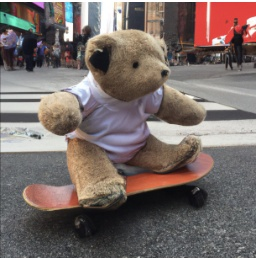

In [7]:
towhee.glob['path']('./teddy.png') \
      .image_decode['path', 'img']() \
      .towhee.clip['img', 'vec'](model_name='clip_vit_b32', modality='image') \
      .tensor_normalize['vec','vec']() \
      .select['img', 'vec']() \
      .show()

In [9]:
towhee.dc['text'](["A teddybear on a skateboard in Times Square."]) \
      .towhee.clip['text','vec'](model_name='clip_vit_b32', modality='text') \
      .tensor_normalize['vec','vec']() \
      .select['text', 'vec']() \
      .show()

text,vec
A teddybear on a skateboard in T...,"[0.028040394, -0.033711948, 8.772181e-05, ...] shape=(512,)"


### Load Image Embeddings into Milvus

We first extract embeddings from images with `clip_vit_32` model and insert the embeddings into Milvus for indexing. Towhee provides a [method-chaining style API](https://towhee.readthedocs.io/en/main/index.html) so that users can assemble a data processing pipeline with operators. 

Here is detailed explanation for other apis of the code:

- `towhee.read_csv('reverse_image_search.csv')`: read tabular data from csv file (`id`, `path` and `label` columns);

- `.runas_op['id', 'id'](func=lambda x: int(x))`: for each row from the data, convert the data type of the column `id` from `str` to `int`;

- `.to_milvus['id', 'vec'](collection=collection, batch=100)`: insert image embedding features in to Milvus;

In [10]:
%%time
collection = create_milvus_collection('text_image_search', 512)

dc = (
    towhee.read_csv('reverse_image_search.csv')
      .runas_op['id', 'id'](func=lambda x: int(x))
      .set_parallel(4)
      .image_decode['path', 'img']()
      .towhee.clip['img', 'vec'](model_name='clip_vit_b32', modality='image')
      .tensor_normalize['vec','vec']()
      .to_milvus['id', 'vec'](collection=collection, batch=100)
)

CPU times: user 5min 30s, sys: 6.81 s, total: 5min 37s
Wall time: 1min 21s


In [11]:
print('Total number of inserted data is {}.'.format(collection.num_entities))

Total number of inserted data is 1000.


### Query Similar Images from Milvus

Now that embeddings for candidate images have been inserted into Milvus, we can query across it for nearest neighbors. Again, we use Towhee to load the input image, compute an embedding vector, and use the vector as a query for Milvus. Because Milvus only outputs image IDs and distance values, we provide a `read_images` function to get the original image based on IDs and display.

text,result_img
A white dog,

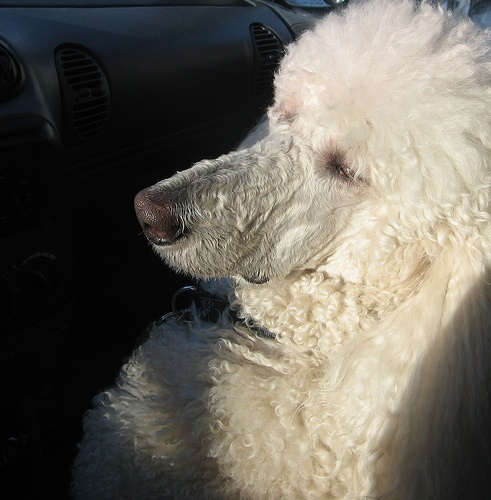
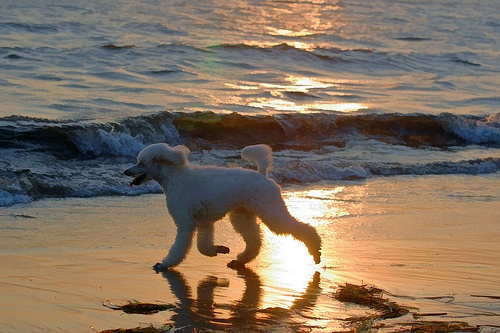
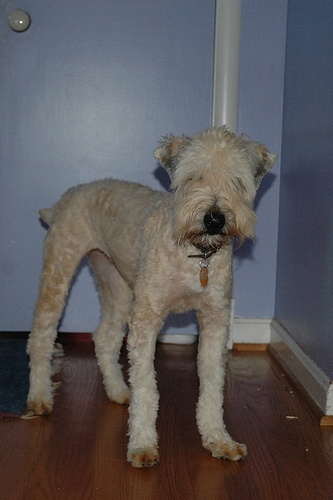
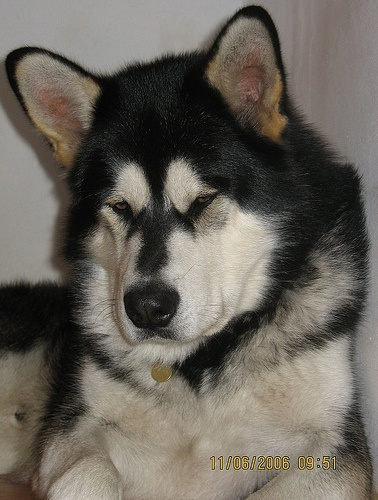
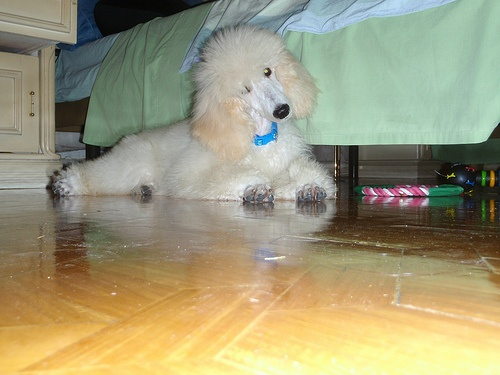

In [17]:
(
    towhee.dc['text'](["A white dog"])
      .towhee.clip['text', 'vec'](model_name='clip_vit_b32', modality='text')
      .tensor_normalize['vec','vec']()
      .milvus_search['vec', 'result'](collection=collection, limit=5)
      .runas_op['result', 'result_img'](func=read_images)
      .select['text', 'result_img']()
      .show()
)

## Deploy as a Microservice

The data pipeline used in our experiments can be converted to a function with `towhee.api` and `as_function()`, as it is presented in [getting started notebook]. We can also convert the data pipeline into a RESTful API with `serve()`, it generates FastAPI services from towhee pipelines.

### Insert Image Data

In [11]:
import towhee
import time
from fastapi import FastAPI
from pymilvus import connections, Collection

app = FastAPI()
connections.connect(host='127.0.0.1', port='19530')
milvus_collection = Collection('text_image_search')

@towhee.register(name='get_path_id')
def get_path_id(path):
    timestamp = int(time.time()*10000)
    id_img[timestamp] = path
    return timestamp

@towhee.register(name='milvus_insert')
class MilvusInsert:
    def __init__(self, collection):
        self.collection = collection

    def __call__(self, *args, **kwargs):
        data = []
        for iterable in args:
            data.append([iterable])
        mr = self.collection.insert(data)
        self.collection.load()
        return str(mr)

with towhee.api['file']() as api:
    app_insert = (
        api.image_load['file', 'img']()
        .save_image['img', 'path'](dir='tmp/images')
        .get_path_id['path', 'id']()
        .towhee.clip['img', 'vec'](model_name='clip_vit_b32',modality='image')
        .tensor_normalize['vec','vec']()
        .milvus_insert[('id', 'vec'), 'res'](collection=milvus_collection)
        .select['id', 'path']()
        .serve('/insert', app)
    )

### Search Similar Image

In [12]:
with towhee.api['file']() as api:
    app_search = (
        api.towhee.clip['text', 'vec'](model_name='clip_vit_b32',modality='text')
        .tensor_normalize['vec','vec']()
        .milvus_search['vec', 'result'](collection=milvus_collection)
        .runas_op['result', 'res_file'](func=lambda res: str([id_img[x.id] for x in res]))
        .select['res_file']()
        .serve('/search', app)
    )

### Count Numbers

In [13]:
with towhee.api() as api:
    app_count = (
        api.map(lambda _: milvus_collection.num_entities)
        .serve('/count', app)
        )

## Release a Showcase

We've done an excellent job on the core functionality of our image search engine. Now it's time to build a showcase with interface. [Gradio](https://gradio.app/) is a great tool for building demos. With Gradio, we simply need to wrap the data processing pipeline via a `search_in_milvus` function:

In [18]:
with towhee.api() as api:
    milvus_search_function = (
        api.towhee.clip(model_name='clip_vit_b32',modality='text')
            .tensor_normalize()
            .milvus_search(collection='text_image_search', limit=5)
            .runas_op(func=lambda res: [id_img[x.id] for x in res])
            .as_function()
    )

In [20]:
milvus_search_function('a green train')

['./train/electric_locomotive/n03272562_6933.JPEG',
 './train/electric_locomotive/n03272562_8598.JPEG',
 './train/steam_locomotive/n04310018_11226.JPEG',
 './train/bullet_train/n02917067_4363.JPEG',
 './train/oxcart/n03868242_10994.JPEG']

In [21]:
import gradio

interface = gradio.Interface(milvus_search_function, 
                             gradio.inputs.Textbox(lines=1),
                             [gradio.outputs.Image(type="file", label=None) for _ in range(5)]
                            )

interface.launch(inline=True, share=True)

Running on local URL:  http://127.0.0.1:7863/
Running on public URL: https://40685.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7fd5a83258e0>,
 'http://127.0.0.1:7863/',
 'https://40685.gradio.app')